## 개요
이 프로젝트에서는 포켓몬 데이터를 사용해서 전설의 포켓몬을 분류하는 이진 분류 모델을 개발합니다. Kaggle의 포켓몬 데이터셋을 데이터 분석과 전처리, 머신러닝 모델 개발에 활용합니다.

## 목차
- 1. 문제 정의
- 2. 데이터 수집
- 3. 데이터 이해
    - 3.1. 데이터 불러오기
    - 3.2. 데이터 구조 분석
    - 3.3. Feature 분석
    - 3.4. Target data 분석
- 4. 데이터 준비
    - 4.1. 문자열 데이터 전처리
- 5. 모델 개발
    - 5.1. 기본 모델
    - 5.2. 베이스라인 모델
    - 5.3. 비교 모델
    - 5.4. 모델 개선
- 6. 회고
- 7. 참고

## 1. 문제 정의
- 데이터의 Name, Type 1, Type 2, Total,	HP,	Attack,	Defense, Sp. Atk,	Sp. Def,	Speed,	Generation과 같은 특성을 통해 전설의 포켓몬인지 구별하는 이진 분류 문제입니다.

- 문제 해결에 대한 성공 지표는 recall로 설정합니다.
  - 데이터가 불균형한 상태 (일반 포켓몬 735마리, 전설 포켓몬 65)이므로 accuracy로 판단하면 정확도는 높을 수 있지만, 소수 클래스인 전설 포켓몬에 대해 제대로 예측하지 못할 수 있기때문에 accuracy를 사용하지 않고 recall을 성공 지표로 선택했습니다.

## 2. 데이터 수집
kaggle의 [포켓몬 데이터셋](https://www.kaggle.com/datasets/abcsds/pokemon)을 활용해 모델의 학습을 진행한다.

In [246]:
import kagglehub

data_path = kagglehub.dataset_download("abcsds/pokemon")

## 3. 데이터 이해

#### 3.1 데이터 불러오기

In [247]:
# Import library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

original_data = pd.read_csv(data_path + "/Pokemon.csv")
pokemon = original_data.copy()

#### 3.2 데이터 구조 파악
- shape
- head
- info
- describe

In [248]:
pokemon.shape

(800, 13)

- 포켓몬이 총 800마리이고, 13개의 속성을 가지고 있다.

In [249]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [250]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


- Type 2 속성에 결측치가 존재한다.

In [251]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [252]:
pokemon.isnull().sum()

,0
#,0
Name,0
Type 1,0
Type 2,386
Total,0
HP,0
Attack,0
Defense,0
Sp. Atk,0
Sp. Def,0


- Type 2에 결측치는 총 386개가 존재한다.

In [253]:
# 전설 포켓몬 데이터
legendary = pokemon[pokemon['Legendary'] == True]
print(legendary.shape)
legendary.head()

(65, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
156,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
157,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
158,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
162,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
163,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True


In [254]:
# 일반 포켓몬 데이터
non_legendary = pokemon[pokemon["Legendary"] == False]
print(non_legendary.shape)
non_legendary.head()

(735, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


- 전설 포켓몬은 65마리, 일반 포켓몬은 735마리가 있다.

#### 3.3 Feature 분석
- \# : 포켓몬 Id number. 성별이 다르지만 같은 포켓몬인 경우 등은 같은 #값을 가진다. int
- Name : 포켓몬 이름. 포켓몬 각각의 이름으로 저장되고, 800개의 포켓몬의 이름 데이터는 모두 다르다. (unique) str
- Type 1 : 첫 번째 속성. 속성을 하나만 가지는 경우 Type 1에 입력된다. str
- Type 2 : 두 번째 속성. 속성을 하나만 가지는 포켓몬의 경우 Type 2는 NaN(결측값)을 가진다. str
- Total : 전체 6가지 스탯의 총합. int
- HP : 포켓몬의 체력. int
- Attack : 물리 공격력. (scratch, punch 등) int
- Defense : 물리 공격에 대한 방어력. int
- Sp. Atk : 특수 공격력. (fire blast, bubble beam 등) int
- Sp. Def : 특수 공격에 대한 방어력. int
- Speed : 포켓몬 매치에 대해 어떤 포켓몬이 먼저 공격할지를 결정. (더 높은 포켓몬이 먼저 공격한다) int
- Generation : 포켓몬의 세대. 현재 데이터에는 6세대까지 있다. int
- Legendary(Target feature) : 전설의 포켓몬 여부. bool

#### 3.3.1 # (ID number)

In [255]:
len(set(pokemon["#"]))

721

- 데이터는 총 800개인데, 집합 자료형은 721개이므로, # 컬럼은 유니크하지 않고, 같은 값을 가지는 케이스가 있다.

In [256]:
pokemon[pokemon["#"] == 6]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


- Charizard의 진화형 포켓몬들의 # 값이 6으로 동일한 걸 확인할 수 있다. #이 같으면 포켓몬이 진화한 경우라고 생각할 수 있다.

#### 3.3.2 Name (이름)

In [257]:
# Name : 이름
len(set(pokemon["Name"]))

800

- Name 컬럼은 고유한 값 800개로 모두 유니크하다.

#### 3.3.3 Type 1 & Type 2 : 포켓몬의 속성

In [258]:
pokemon.loc[[6, 10]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False


- 6번 포켓몬인 Charizard Fire, Flying 속성을 가졌고, 8번 포켓몬인 Wartortle는 Water 속성만 가지고 있다.
- 포켓몬은 하나 또는 두 개의 속성을 가질 수 있고, 속성이 1개인 경우 Type 1에만 표시된다.

In [259]:
len(list(set(pokemon["Type 1"]))), len(list(set(pokemon["Type 2"])))

(18, 19)

- Type 1 속성은 18개, Type 2 속성은 19개가 있다.

In [260]:
set(pokemon["Type 2"]) - set(pokemon["Type 1"])

{nan}

- 차집합을 확인해보면 Type 1과 Type 2의 차이는 NaN값이므로, 결측치를 제외하면 모두 같은 데이터가 들어가 있다.

In [261]:
types = list(set(pokemon["Type 1"]))
print(len(types))
print(types)

18
['Flying', 'Water', 'Poison', 'Ground', 'Normal', 'Dragon', 'Electric', 'Dark', 'Psychic', 'Ghost', 'Bug', 'Ice', 'Grass', 'Steel', 'Fighting', 'Rock', 'Fire', 'Fairy']


In [262]:
pokemon["Type 2"].isna().sum()

386

- 386개의 포켓몬이 속성을 하나만 가지고 있고, 나머지는 2개 속성을 가진다.

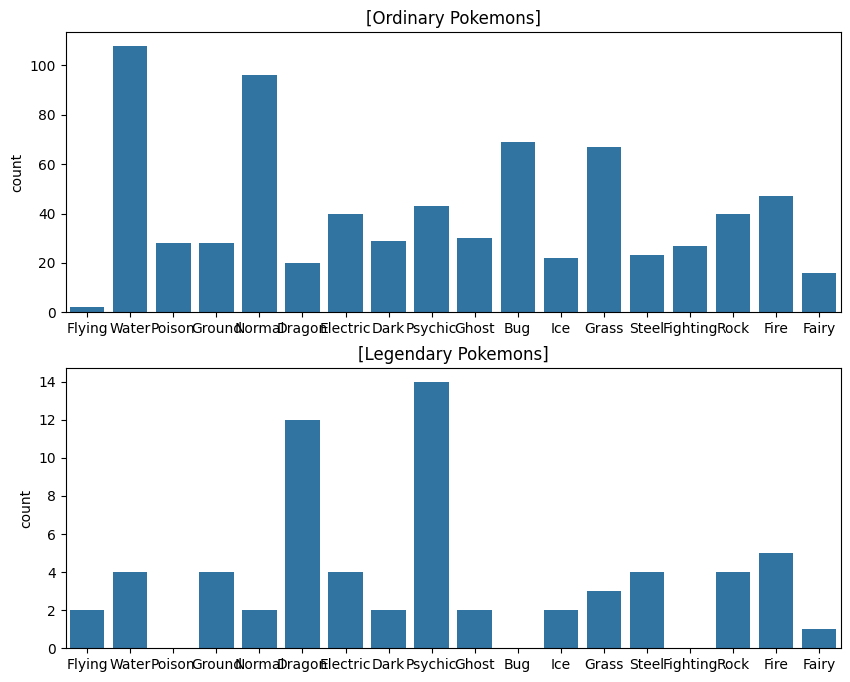

In [263]:
# Type 1 데이터 분포 plot
plt.figure(figsize=(10, 8))

plt.subplot(211)
sns.countplot(data=non_legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

- 전설 포켓몬은 Psychic, Dragon  속성을 가진 경우가 많고, 일반 포켓몬은 Water, Normal, Bug, Grass 속성이 많다는 차이점이 있다.

In [264]:
pd.pivot_table(pokemon, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False)

,Legendary
Type 1,
Flying,0.500000
Dragon,0.375000
Psychic,0.245614
Steel,0.148148
Ground,0.125000
Fire,0.096154
Electric,0.090909
Rock,0.090909
Ice,0.083333


- Legendary 비율이 가장 높은 속성은 Flying으로 50%에 해당된다. 날아다니는 포켓몬이 높은 비율로 전설 포켓몬임을 알 수 있다.

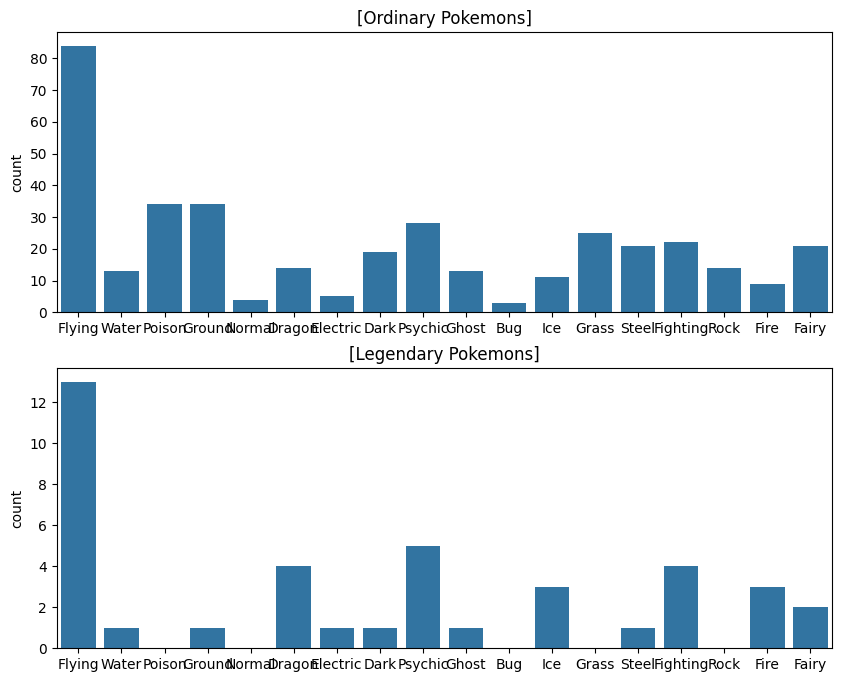

In [265]:
# Type 2 데이터 분포 plot
plt.figure(figsize=(10, 8))

plt.subplot(211)
sns.countplot(data=non_legendary, x="Type 2", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 2", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

- Type 2에서 Flying 속성의 경우 두 경우 가장 많지만, 일반 포켓몬에는 Grass, Rock, Poison 속성이 많은 반면 전설 포켓몬은 하나도 없다.

- 여전히 Dragon, Psychic과 더불어 Fighting과 같은 속성이 많다.

In [266]:
pd.pivot_table(pokemon, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False)

,Legendary
Type 2,
Fire,0.250000
Dragon,0.222222
Ice,0.214286
Electric,0.166667
Fighting,0.153846
Psychic,0.151515
Flying,0.134021
Fairy,0.086957
Water,0.071429


- Type 2에서는 Fire 속성 포켓몬의 Legendary 비율이 25%로 가장 높다.

#### 3.3.3 Total & stat

In [267]:
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats

['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

In [268]:
print("#0 pokemon: ", pokemon.loc[0, "Name"])
print("total: ", int(pokemon.loc[0, "Total"]))
print("stats: ", list(pokemon.loc[0, stats]))
print("sum of all stats: ", sum(list(pokemon.loc[0, stats])))

#0 pokemon:  Bulbasaur
total:  318
stats:  [45, 49, 49, 65, 65, 45]
sum of all stats:  318


- total은 모든 스탯의 총합이고, 스탯은 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'로 6개가 있다.

In [269]:
same_total_count = (pokemon['Total'] == pokemon[stats].sum(axis=1)).sum()
same_total_count

800

- 모든 포켓몬의 stats의 총합이 total과 일치한다.

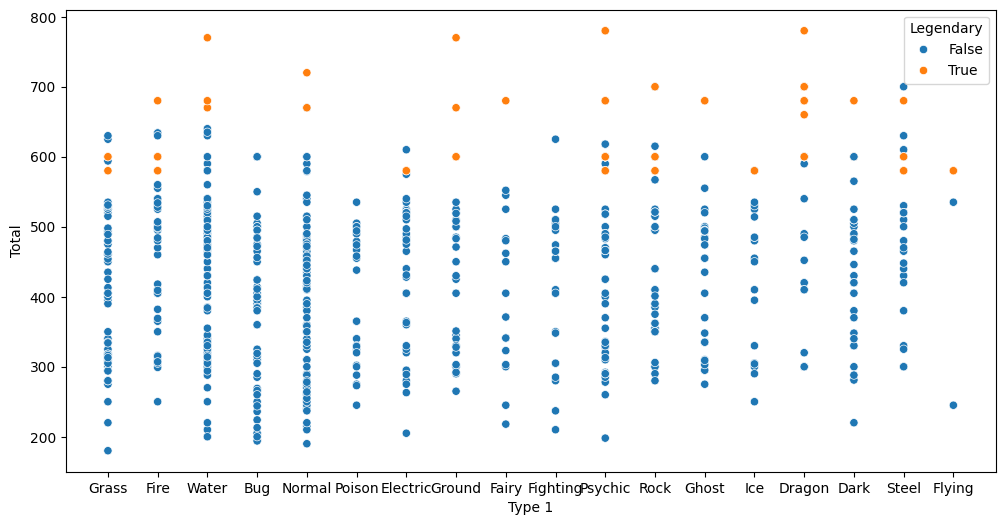

In [270]:
# Total값에 따른 분포 plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

sns.scatterplot(data=pokemon, x="Type 1", y="Total", hue="Legendary")
plt.show()

- 전설 포켓몬은 모든 스탯의 합이 전부 500이 넘는 걸 확인할 수 있다. 스탯이 높으면 전설의 포켓몬일 가능성이 높다.

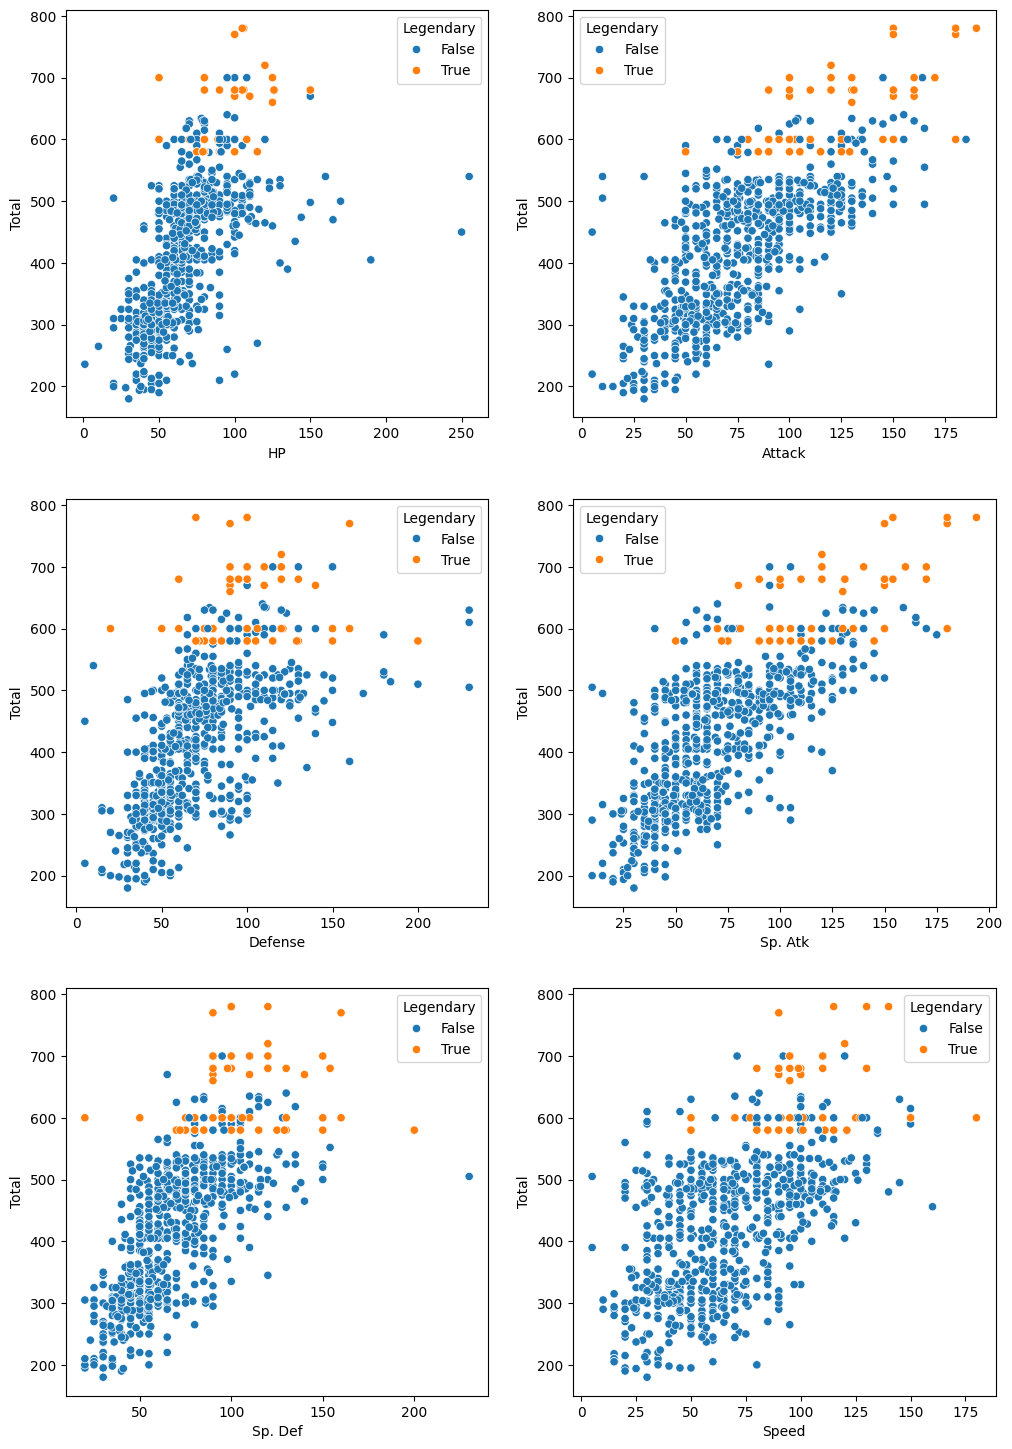

In [271]:
# 세부스탯: HP, Attack, Defense, Sp. Atk, Sp. Def, Speed

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(12, 18)

# "HP" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="HP", hue="Legendary", ax=ax1)

# "Attack" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Attack", hue="Legendary", ax=ax2)

# "Defense" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Defense", hue="Legendary", ax=ax3)

# "Sp. Atk" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Atk", hue="Legendary", ax=ax4)

# "Sp. Def" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Def", hue="Legendary", ax=ax5)

# "Speed" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Speed", hue="Legendary", ax=ax6)

plt.show()

- HP, Defense, Sp. Def : 일반 포켓몬이 더 높은 경우가 있지만, Total 값은 높지 않다. 즉, 특정 스탯 및 속성에 특화된 포켓몬일 것이다.
- Attack, Sp. Atk, Speed : 전설 포켓몬이 각 스탯의 최대치를 차지하고 있다.

#### 3.3.4 Generation : 포켓몬의 세대

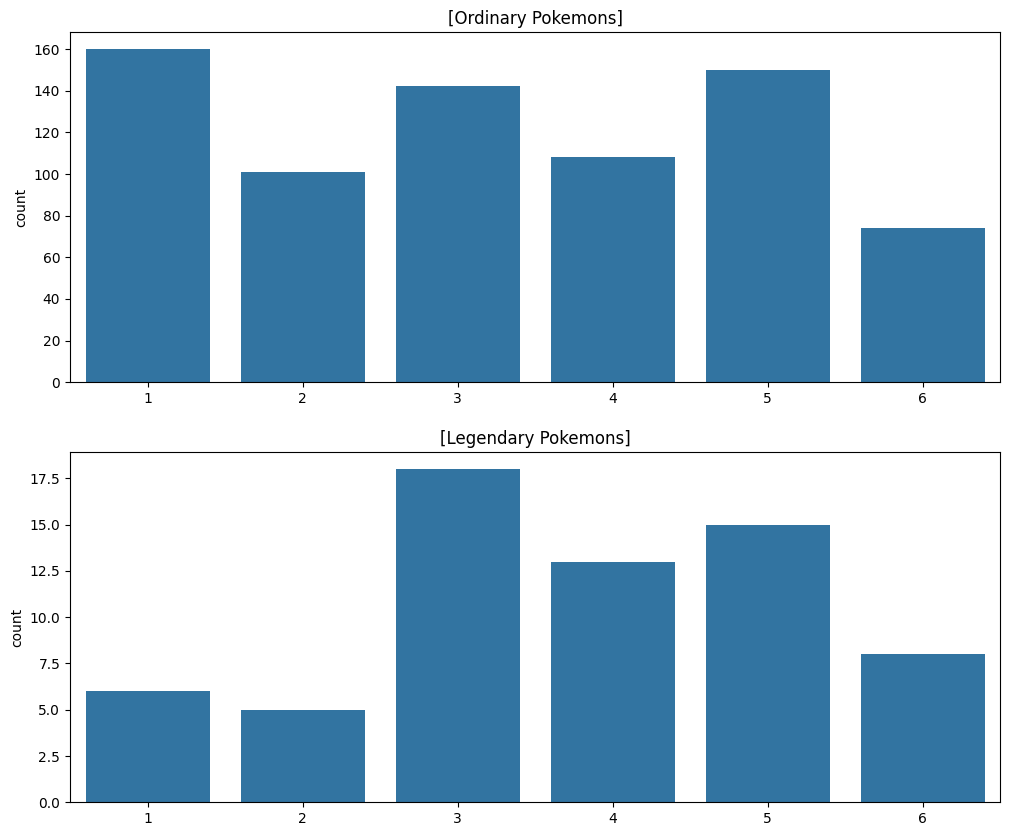

In [272]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.countplot(data=non_legendary, x="Generation").set_xlabel('')
plt.title("[Ordinary Pokemons]")
plt.subplot(212)
sns.countplot(data=legendary, x="Generation").set_xlabel('')
plt.title("[Legendary Pokemons]")
plt.show()

- 전설 포켓몬은 1, 2세대에는 많지 않았고 3세대부터 많았다가 6세대에 줄어들었다.

#### 3.4 Target data 분석

#### 3.4.1 Total Feature

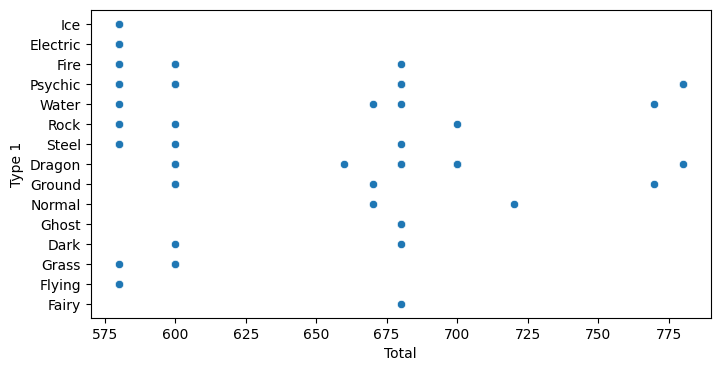

In [273]:
# 전설 포켓몬의 Total 값
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.scatterplot(data=legendary, y="Type 1", x="Total")
plt.show()

- 전설 포켓몬의 Total 값이 600과 같은 특정한 값에 몰려있다는 특징이 있다.

In [274]:
sorted(list(set(legendary["Total"])))

[580, 600, 660, 670, 680, 700, 720, 770, 780]

- 전설 포켓몬이 가지는 고유한 Total 값은 9개 밖에 없다.

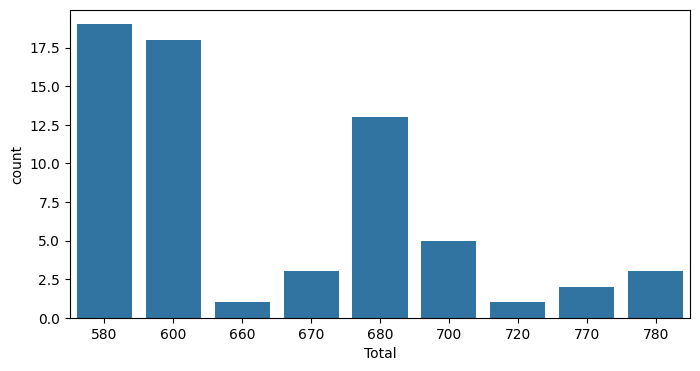

In [275]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.countplot(data=legendary, x="Total")
plt.show()

In [276]:
round(65 / 9, 2)

7.22

- 65마리의 전설 포켓몬이 9개의 Total 값만 가지고 있다는 말은 약 7.22마리가 같은 Total을 가진다는 의미와 같다.

In [277]:
# 일반 포켓몬의 Total 값 집합
sorted(list(set(non_legendary["Total"])))[:10]

[180, 190, 194, 195, 198, 200, 205, 210, 213, 215]

In [278]:
len(sorted(list(set(non_legendary["Total"]))))

195

In [279]:
round(735 / 195, 2)

3.77

- 일반 포켓몬은 195가지의 Total 속성값을 가지고, 약 3.77마리가 같은 Total 스탯 값을 가진다.
- Total값의 다양성은 일반 포켓몬이 전설의 포켓몬보다 약 두 배이다. 즉, 전설의 포켓몬의 Total값은 다양하지 않다.
- 포켓몬의 Total 값이 전설 포켓몬의 값들 집합에 포함되는 지 여부는 전설 포켓몬을 결정하는데 영향을 미친다.
- 전설의 포켓몬의 Total 값 중에는 일반 포켓몬이 가지지 못하는 Total값이 존재한다.
- 결론적으로 Total 값은 전설의 포켓몬을 예측하는데 중요한 속성이라고 할 수 있다.

#### 3.4.2 Name Feature

In [280]:
n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
names = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)
names

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
1,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True
2,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True
3,380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
4,380,LatiasMega Latias,Dragon,Psychic,700,80,100,120,140,150,110,3,True
5,381,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,True
6,381,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,True
7,382,Kyogre,Water,NaN,670,100,100,90,150,140,90,3,True
8,382,KyogrePrimal Kyogre,Water,NaN,770,100,150,90,180,160,90,3,True
9,383,Groudon,Ground,NaN,670,100,150,140,100,90,90,3,True


- "MewTwo", "Latias", "Latios", "Kyogre", "Groudon", "Rayquaza", "Kyurem" 등의 포켓몬은 비슷한 이름을 가진 포켓몬이 다수 존재한다.
- 또한, Forme가 들어가는 전설의 포켓몬이 있는 경우도 있다. 여기서 forme는 폼을 의미하고, 포켓몬이 폼체인지를 하고난 후 모습이다.

In [281]:
formes = names[13:23]
formes

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
13,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
14,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
15,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
16,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True
17,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True
18,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
19,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True
20,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True
21,645,LandorusIncarnate Forme,Ground,Flying,600,89,125,90,115,80,101,5,True
22,645,LandorusTherian Forme,Ground,Flying,600,89,145,90,105,80,91,5,True


- forme가 들어가면 이는 전설의 포켓몬일 확률이 높다.

In [282]:
# name count
legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))
legendary.head()

<ipython-input-282-8ed71e9294f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
156,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,8
157,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,6
158,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,7
162,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,6
163,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,19


In [283]:
non_legendary["name_count"] = non_legendary["Name"].apply(lambda i: len(i))
non_legendary.head()

<ipython-input-283-dd26926bfe59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_legendary["name_count"] = non_legendary["Name"].apply(lambda i: len(i))


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


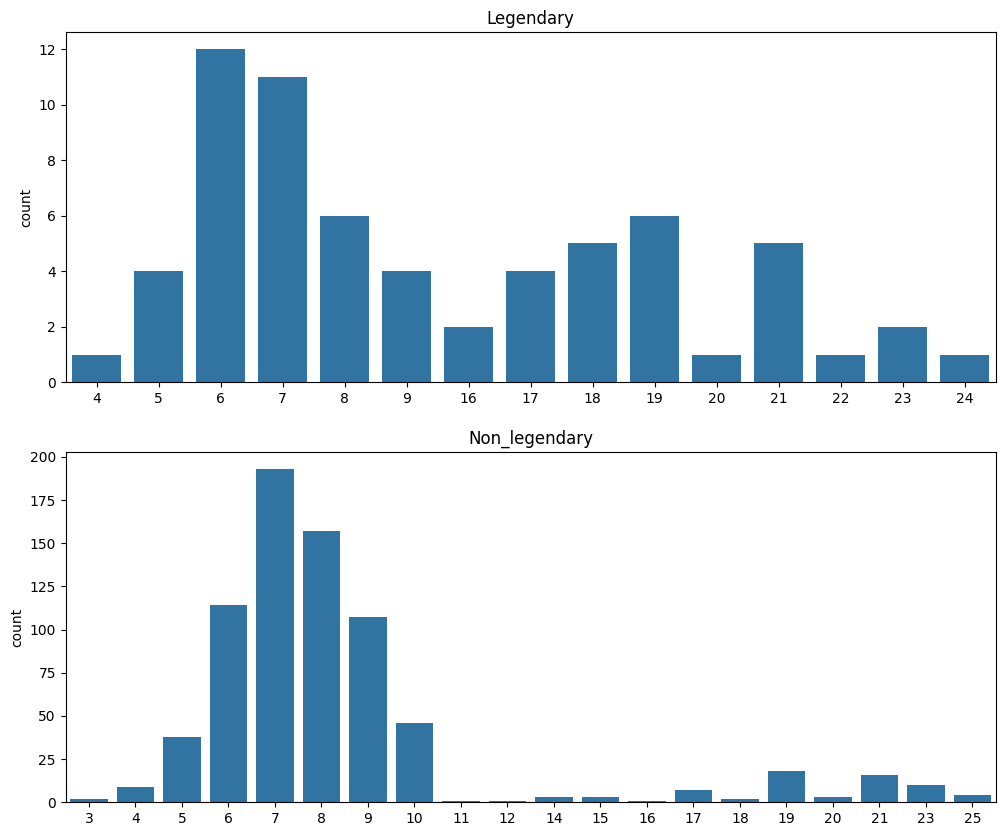

In [284]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.countplot(data=legendary, x="name_count").set_xlabel('')
plt.title("Legendary")
plt.subplot(212)
sns.countplot(data=non_legendary, x="name_count").set_xlabel('')
plt.title("Non_legendary")
plt.show()

- 전설의 포켓몬은 16 이상의 긴 이름을 가진 포켓몬이 많은 반면, 일반 포켓몬은 10 이상의 길이를 가지는 이름의 빈도가 아주 낮다.

In [285]:
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")

41.54 %


- 전설의 포켓몬의 이름이 10 이상일 확률은 41.54%이다.

In [286]:
print(round(len(non_legendary[non_legendary["name_count"] > 9]) / len(non_legendary) * 100, 2), "%")

15.65 %


- 반면에 일반 포켓몬의 이름이 10 이상일 확률은 15.65%로 약 2.5배 차이가 난다.
- 전설 포켓몬에서 높은 빈도를 가진 이름들이 존재한다.
- 전설 포켓몬은 긴 이름을 가졌을 확률이 높다.

## 4. 데이터 준비

#### 4.1 문자열 데이터 전처리

#### 4.1.1 포켓몬 이름의 길이
- name_count : 이름의 길이를 나타내는 속성 int
- long_name : 이름이 10이상인지 확인하는 속성 bool

In [289]:

pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


In [290]:
pokemon["long_name"] = pokemon["name_count"] >= 10
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


- 전설의 포켓몬을 분류할 때, name_count 컬럼과 long_name 컬럼 중 어느 것이 유리할 지는 아직 모르기때문에 둘 다 활용한다.

#### 4.1.2 전설의 포켓몬 이름에 자주 나타나는 토큰
- most_common : 포켓몬의 이름에 전설의 포켓몬의 이름에서 가장 많이 나타나는 10개의 토큰이 포함되는 지 여부는 나타내는 속성 bool

In [291]:
# 알파벳이 아닌 문자가 들어간 경우 전처리
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7,False,Diancie
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19,True,DiancieMegaDiancie
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19,True,HoopaHoopaConfined
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18,True,HoopaHoopaUnbound
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9,False,Volcanion


In [292]:
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False,Bulbasaur,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False,Ivysaur,True
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False,Venusaur,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True,VenusaurMegaVenusaur,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True,Charmander,True


In [293]:
print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

(9, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran♀,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran♂,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetch'd,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon2,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho-oh,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon-Z,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


- 알파벳이 아닌 다른 문자가 들어간 경우에 대한 전처리를 진행해야한다.

In [294]:
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [295]:
print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

(9, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [296]:
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon[pokemon["name_isalpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha


- 전처리 후 name_isalpha 컬럼이 False인 경우가 없으므로 모든 이름이 알파벳으로만 이루어졌음을 알 수 있다.

In [297]:
# Tokenize 함수 정의
import re
from collections import Counter

def tokenize(name):
    tokens = []
    name_split = name.split(" ")
    for part_name in name_split:
        a = re.findall('[A-Z][a-z]*', part_name)
        tokens.extend(a)
    return np.array(tokens)

In [298]:
all_tokens = list(legendary["Name"].apply(tokenize).values)

token_set = []
for token in all_tokens:
    token_set.extend(token)

print(len(set(token_set)))
print(token_set)

65
['Articuno', 'Zapdos', 'Moltres', 'Mewtwo', 'Mewtwo', 'Mega', 'Mewtwo', 'X', 'Mewtwo', 'Mega', 'Mewtwo', 'Y', 'Raikou', 'Entei', 'Suicune', 'Lugia', 'Ho', 'Regirock', 'Regice', 'Registeel', 'Latias', 'Latias', 'Mega', 'Latias', 'Latios', 'Latios', 'Mega', 'Latios', 'Kyogre', 'Kyogre', 'Primal', 'Kyogre', 'Groudon', 'Groudon', 'Primal', 'Groudon', 'Rayquaza', 'Rayquaza', 'Mega', 'Rayquaza', 'Jirachi', 'Deoxys', 'Normal', 'Forme', 'Deoxys', 'Attack', 'Forme', 'Deoxys', 'Defense', 'Forme', 'Deoxys', 'Speed', 'Forme', 'Uxie', 'Mesprit', 'Azelf', 'Dialga', 'Palkia', 'Heatran', 'Regigigas', 'Giratina', 'Altered', 'Forme', 'Giratina', 'Origin', 'Forme', 'Darkrai', 'Shaymin', 'Land', 'Forme', 'Shaymin', 'Sky', 'Forme', 'Arceus', 'Victini', 'Cobalion', 'Terrakion', 'Virizion', 'Tornadus', 'Incarnate', 'Forme', 'Tornadus', 'Therian', 'Forme', 'Thundurus', 'Incarnate', 'Forme', 'Thundurus', 'Therian', 'Forme', 'Reshiram', 'Zekrom', 'Landorus', 'Incarnate', 'Forme', 'Landorus', 'Therian', 'Form

- 중복된 값을 제외하고 총 65개의 토큰이 있다.

In [299]:
most_common = Counter(token_set).most_common(10)
most_common

[('Forme', 15),
 ('Mega', 6),
 ('Mewtwo', 5),
 ('Kyurem', 5),
 ('Deoxys', 4),
 ('Hoopa', 4),
 ('Latias', 3),
 ('Latios', 3),
 ('Kyogre', 3),
 ('Groudon', 3)]

- Forme가 15번이나 쓰였고, 진화를 했을 때 붙는 이름인 Mega도 6번 사용된 걸 확인할 수 있다.
- 전체 65마리인 전설의 포켓몬에서 위와 같은 횟수로 나타났다는 건 큰 의미가 있다.

In [300]:
# 전설의 포켓몬 이름에 등장하는 토큰이 포켓몬의 이름에 있는지의 여부를 나타내는 컬럼 생성
for token, _ in most_common:
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Forme,Mega,Mewtwo,Kyurem,Deoxys,Hoopa,Latias,Latios,Kyogre,Groudon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,False,False,False,False,False,False,False,False,False,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,...,False,False,False,False,False,False,False,False,False,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,...,False,True,False,False,False,False,False,False,False,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,...,False,True,False,False,False,False,False,False,False,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,...,False,False,False,False,False,False,False,False,False,False


- 전설의 포켓몬에서 자주 나타나는 10개 토큰에 대해 포켓몬의 이름이 각각 포함되는지 여부를 확인하는 10개의 컬럼을 생성

#### 4.1.3 Type 1, 2 범주형 데이터 one-hot encoding

In [301]:
print(types)

['Flying', 'Water', 'Poison', 'Ground', 'Normal', 'Dragon', 'Electric', 'Dark', 'Psychic', 'Ghost', 'Bug', 'Ice', 'Grass', 'Steel', 'Fighting', 'Rock', 'Fire', 'Fairy']


In [302]:
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)

pokemon[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Flying,Water,Poison,Ground,Normal,Dragon,Electric,Dark,Psychic,Ghost,Bug,Ice,Grass,Steel,Fighting,Rock,Fire,Fairy
0,Grass,Poison,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,Grass,Poison,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,Grass,Poison,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,Grass,Poison,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,Fire,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


- one-hot encoding을 사용하면 범주형 데이터의 종류 갯수만큼 컬럼이 추가되는 문제가 있지만, 18개이므로 적당하다.

## 5. 모델 개발
- 기본 모델 : Feature Engineering을 수행하기 전 Decision Tree model
- 베이스라인 모델 : Feature Engineering을 수행한 이후 Decision Tree model
- 비교 모델 : Decision Tree 이외의 model

#### 5.1 기본 모델

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data load
basic_model_data = original_data.copy()
basic_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [304]:
# 데이터에서 feature와 target 분리
# 의미없는 컬럼인 #과 문자열 데이터 Name, Type 1, Type 2는 제외한다.
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
target = ['Legendary']

X = basic_model_data[features]
y = basic_model_data[target]

# Data 분리
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 15
                                                    )

# Assign model
model = DecisionTreeClassifier(random_state=25)

# Model train, predict
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
cm

array([[144,   3],
       [  5,   8]])

- 총 160개의 학습 데이터 중 FP와 FN은 합쳐서 8개뿐이니 나쁘지 않은 결과라고 할 수 있습니다.

In [305]:
accuracy = np.trace(cm) / np.sum(cm)
accuracy

0.95

- 정확도는 95%로 나쁘지 않아보인다. 하지만, 전체 800마리 중, 단 65마리만 전설의 포켓몬이고, 735마리는 일반 포켓몬이기때문에 800마리를 전부 다 일반 포켓몬으로 예측하더라도, 735마리는 일단 맞히고 들어간다는 뜻이다.
- 즉, 아무런 학습을 안 하고 모든 답을 하나로 찍어도, 735 / 800 * 100 = 92%의 정확도를 달성할 수 있기때문에 정확도로 모델을 평가하는 건 의미가 없다.

In [306]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



- recall 값이 0.62로 낮은 걸 볼 수 있다.
- recall이 낮다는 것은 FN값이 높다는 것을 뜻한다. 즉, 전설의 포켓몬인데 일반 포켓몬이라고 판단하는 경우가 많다고 볼 수 있다.
- 불균형 데이터에서는 적은 양의 Positive인 전설의 포켓몬을 잘 잡아내는 것이 중요하다.

#### 5.2 베이스라인 모델
4. 데이터 준비 과정을 통해 Feature Engineering을 진행한 pokemon 데이터로 모델을 학습한다.

In [307]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data load
baseline_model_data = pokemon.copy()
baseline_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   #             800 non-null    int64 
 1   Name          800 non-null    object
 2   Type 1        800 non-null    object
 3   Type 2        414 non-null    object
 4   Total         800 non-null    int64 
 5   HP            800 non-null    int64 
 6   Attack        800 non-null    int64 
 7   Defense       800 non-null    int64 
 8   Sp. Atk       800 non-null    int64 
 9   Sp. Def       800 non-null    int64 
 10  Speed         800 non-null    int64 
 11  Generation    800 non-null    int64 
 12  Legendary     800 non-null    bool  
 13  name_count    800 non-null    int64 
 14  long_name     800 non-null    bool  
 15  Name_nospace  800 non-null    object
 16  name_isalpha  800 non-null    bool  
 17  Forme         800 non-null    bool  
 18  Mega          800 non-null    bool  
 19  Mewtwo  

- basic_model_data와 baseline_model_data를 비교해보면 전처리 후 다양한 특성이 생긴 걸 확인할 수 있다.

In [309]:
# 데이터에서 feature와 target 분리
drop_col = ['Name', 'Type 1', 'Type 2', '#', 'Name_nospace', 'name_isalpha', 'Legendary']
target = ['Legendary']


X = baseline_model_data.drop(columns=drop_col)
y = baseline_model_data[target]

# Data 분리
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 15
                                                    )

# Assign model
model = DecisionTreeClassifier(random_state=25)

# Model train, predict
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
cm

array([[141,   6],
       [  1,  12]])

In [310]:
accuracy = np.trace(cm) / np.sum(cm)
accuracy

0.95625

In [311]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



- 기본 모델에서 약 0.62에 그쳤던 recall값이 무려 0.92까지 올라간 걸 확인할 수 있다.

#### 5.3 비교 모델
- RandomForestClassifier

In [324]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Data load
comparison_model_data = pokemon.copy()

# 데이터에서 feature와 target 분리
drop_col = ['Name', 'Type 1', 'Type 2', '#', 'Name_nospace', 'name_isalpha', 'Legendary']
target = ['Legendary']


X = comparison_model_data.drop(columns=drop_col)
y = comparison_model_data[target]

# Data 분리
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 15
                                                    )

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=25, class_weight='balanced', max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=25),
    'Random Forest class_weight balance': RandomForestClassifier(random_state=25, class_weight='balanced'),
    'Random Forest max_depth 5': RandomForestClassifier(random_state=25, max_depth=5),
    'Random Forest class_weight balance and max_depth 5': RandomForestClassifier(random_state=25, class_weight='balanced', max_depth=5),
    'Random Forest class_weight balance and max_depth 10': RandomForestClassifier(random_state=25, class_weight='balanced', max_depth=10),
}

# Result
results = {}

for name, model in models.items():
  curr_model = models[name]
  curr_model.fit(x_train, y_train.values.ravel())
  y_pred = curr_model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  results[name] = {
      'accuracy': accuracy,
      'predictions': y_pred
  }

# Comparison result
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {result['accuracy']}")
    print("Classification Report:")
    print(classification_report(y_test, result['predictions']))


Decision Tree:
Accuracy: 0.95625
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160


Random Forest:
Accuracy: 0.9625
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       147
        True       0.73      0.85      0.79        13

    accuracy                           0.96       160
   macro avg       0.86      0.91      0.88       160
weighted avg       0.97      0.96      0.96       160


Random Forest class_weight balance:
Accuracy: 0.95625
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74   

- Decision tree 모델과 비교하기 위해 Random forest 모델을 사용해보았다.
- Randon forest 모델의 하이퍼 파라미터인 class weight 옵션을 활용해서 불균형한 데이터에 가중치를 조정해볼 수 있고, max_depth를 통해 학습의 깊이를 조절할 수 있다. 각각 옵션을 적용해본 모델과 두 가지 옵션을 적용한 모델을 비교해보았다.
- class weight, max_depth를 하나씩 적용한 경우 recall에 대한 성능이 내려가는 걸 확인할 수 있었고, 두 개를 동시에 사용하면 성능이 개선되는 것을 확인할 수 있었다.

#### 5.4 모델 개선
베이스라인의 비교 모델인 Random forest의 하이퍼파라미터를 조정해서 성능을 개선해봅니다.

In [327]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Data load
comparison_model_data = pokemon.copy()

# 데이터에서 feature와 target 분리
drop_col = ['Name', 'Type 1', 'Type 2', '#', 'Name_nospace', 'name_isalpha', 'Legendary']
target = ['Legendary']


X = comparison_model_data.drop(columns=drop_col)
y = comparison_model_data[target]

# Data 분리
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 15
                                                    )

# Params
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

# Grid search
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(x_train, y_train.values.ravel())
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9,
                       n_estimators=25)


- Grid search를 통해 얻은 하이퍼파라미터 값으로 모델을 설정한다.

In [329]:
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(x_train, y_train.values.ravel())
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                       n_estimators=25)


- Random search를 통해 얻은 하이퍼파라미터 값으로 모델을 설정한다.

In [330]:
models = {
    'Random Forest': RandomForestClassifier(random_state=25),
    'Random Forest class weight balance': RandomForestClassifier(random_state=25, class_weight='balanced'),
    'Random Forest grid': RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9,
                       n_estimators=25),
    'Random Forest random': RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                       n_estimators=25),
    'Random Forest grid and class weight balance': RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9,
                       n_estimators=25, class_weight='balanced'),
    'Random Forest random and class weight balance': RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                       n_estimators=25, class_weight='balanced'),
}

# Result
results = {}

for name, model in models.items():
  curr_model = models[name]
  curr_model.fit(x_train, y_train.values.ravel())
  y_pred = curr_model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  results[name] = {
      'accuracy': accuracy,
      'predictions': y_pred
  }

# Comparison result
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {result['accuracy']}")
    print("Classification Report:")
    print(classification_report(y_test, result['predictions']))


Random Forest:
Accuracy: 0.9625
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       147
        True       0.73      0.85      0.79        13

    accuracy                           0.96       160
   macro avg       0.86      0.91      0.88       160
weighted avg       0.97      0.96      0.96       160


Random Forest class weight balance:
Accuracy: 0.95625
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       147
        True       0.71      0.77      0.74        13

    accuracy                           0.96       160
   macro avg       0.85      0.87      0.86       160
weighted avg       0.96      0.96      0.96       160


Random Forest grid:
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       147
        True       0.63      0.92      0.75 

- 재현율이 높으면서도 f1-score가 낮지 않고 조화로운 모델은 random search를 적용해서 하이퍼파라미터률 튜닝한 모델인 'Random Forest random'이다.

## 6. 회고
이번 프로젝트를 통해 머신러닝 모델 개발 프로세스에 대해 이해할 수 있었습니다. 또한, 데이터 전처리를 통해 모델의 성능이 향상되는 것을 시각적으로 확인하는 과정에서 데이터를 탐색하고, 의미있는 부분을 도출하는 Feature Engineering의 중요성을 알게되었습니다.

데이터 전처리 이후에 Decision tree, Random forest, GBM, KNN 등 여러 가지 모델을 활용해보면서 모델을 비교해보는 과정에서 모델 간의 차이점과 현재 활용하고 있는 데이터셋에 맞게 튜닝하는 것에 대한 부족함을 느낄 수 있었습니다.

예를 들어 5.3 비교 모델에서 Random forest의 옵션을 조정해보았는데, 모델에 대해 정확한 이해없이 단순히 숫자를 바꿔보면서 성능을 비교하고 있는 제 모습을 발견했습니다. Decision tree와 다른 점은 무엇이고, 현재 문제를 해결하기 위해 모델을 어떻게 튜닝해야할지 감을 못 잡고 있다는 느낌을 받았습니다.

따라서, 앞으로는 모델 간의 차이점을 학습하고, 해결해야하는 문제에 어떤 모델이 적합하고, 어떻게 튜닝해야하는지에 대해 명확히 이해한 상태에서 모델을 비교할 수 있게 학습할 계획입니다.

## 7. 참고
- https://scikit-learn.org/1.5/modules/tree.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/1.5/modules/ensemble.html#forest
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=ko
- https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/